/var/folders/_j/ctxbrk0926zg7z8n7jc3xpp00000gn/T/ipykernel_76642/1864043773.py:52: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/var/folders/_j/ctxbrk0926zg7z8n7jc3xpp00000gn/T/ipykernel_76642/1864043773.py:68: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



iter:50 training loss: 0.017365971580147743, val loss: 0.017300723120570183
iter:100 training loss: 0.013079141266644001, val loss: 0.012992942705750465
iter:150 training loss: 0.012757440097630024, val loss: 0.012711470015347004
iter:200 training loss: 0.012643764726817608, val loss: 0.012640821747481823
iter:250 training loss: 0.012629968114197254, val loss: 0.012541932985186577
iter:300 training loss: 0.012628143653273582, val loss: 0.012560459785163403
iter:350 training loss: 0.012573291547596455, val loss: 0.012508116662502289
iter:400 training loss: 0.012684466317296028, val loss: 0.012559806928038597
iter:450 training loss: 0.012626501731574535, val loss: 0.012594947591423988
iter:500 training loss: 0.0125961285084486, val loss: 0.012583638541400433
iter:550 training loss: 0.012576527893543243, val loss: 0.012548588216304779
iter:600 training loss: 0.012615257874131203, val loss: 0.01255176030099392
iter:650 training loss: 0.012604880146682262, val loss: 0.012536202557384968
ite

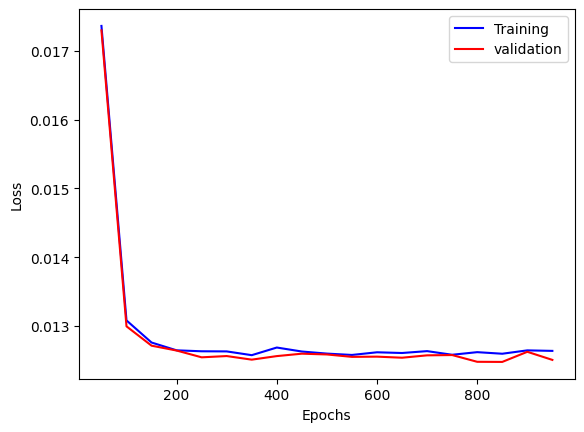

In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.express as px


def visualise_tensor(data):
    data = data.detach().numpy()

    colormap = 'RdBu_r'
    fig = px.imshow(data, color_continuous_scale=colormap, zmin=-1, zmax=1)
    fig.show()
    fig.data = ()

weight_penalty_coefficient = 0.01

input_size = 20
hidden_layer_size= 5
output_size = input_size
learning_rate = 0.01
max_iters = 1000
dataset_size = 1024*32
sparsity = torch.rand(input_size)
batch_size = 32

decay_factor = 0.95
iters = []
loss_value = []
val_loss_value = []

imp_vector =torch.tensor([0.7**0 for i in range(input_size)])
imp_vector = torch.rand(input_size)



def get_l1_penalty():
    l1_penalty = 0
    for param in model.parameters():
        if param.requires_grad:
            l1_penalty += torch.norm(param, p=1)
    return l1_penalty

def sample_data():
    sparsity_vector = sparsity
    a, b = training_dataset.shape
    
    # Make sure sparsity_vector is a tensor and has the same device as training_dataset
    sparsity_vector = torch.tensor(sparsity_vector, device=training_dataset.device)
    
    # Reshape the sparsity vector to be broadcastable over the features dimension
    sparsity_vector = sparsity_vector.view(1, -1)
    
    # Create a sparsity matrix where each feature column has its corresponding sparsity
    sparsity_mat = torch.bernoulli(torch.full((a, b), 1.0) * sparsity_vector)
    
    X = training_dataset * sparsity_mat
    return X, X

def sample_validation_data():
    sparsity_vector = sparsity
    a, b = validation_dataset.shape
    
    # Make sure sparsity_vector is a tensor and has the same device as training_dataset
    sparsity_vector = torch.tensor(sparsity_vector, device=training_dataset.device)
    
    # Reshape the sparsity vector to be broadcastable over the features dimension
    sparsity_vector = sparsity_vector.view(1, -1)
    
    # Create a sparsity matrix where each feature column has its corresponding sparsity
    sparsity_mat = torch.bernoulli(torch.full((a, b), 1.0) * sparsity_vector)
    
    X = validation_dataset * sparsity_mat
    return X, X


def get_loss(target, output):
    loss = (imp_vector*((target-output)**2)).mean()
    return loss

def get_negative_weight_penalty():
    l1 = 0
    for layer in model.layers:
        l1+=torch.sum(F.relu(-layer.weight))
    return weight_penalty_coefficient*l1

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_layer_size, bias= False)
        self.decoder = nn.Linear(hidden_layer_size, output_size)
        self.layers = [self.encoder,self.decoder]

        self.decoder.weight.data = self.encoder.weight.data.t()

        self.relu = nn.ReLU()
    
    def forward(self, input, targets = None):
         
        logits = self.encoder(input)
        logits = self.decoder(logits)
        logits = self.relu(logits)
        if targets is None:
            return logits
        else:
            loss = get_loss(targets, logits)
            return logits, loss

training_dataset = torch.rand(dataset_size, input_size)
validation_dataset = torch.rand(int(dataset_size/2), input_size)
output = input


model = Model()

LOAD_MODEL = False
PATH = "models/basic_linear_0.99.bin"
if LOAD_MODEL:
    model = Model()
    model.load_state_dict(torch.load(PATH))
    model.eval()
else:
    optimizer = torch.optim.Adam(model.parameters() , learning_rate, weight_decay= 1e-5)
    start_time = time.time()
    step_value = max_iters/20
    for i in range(1, max_iters):
        X, Y = sample_data()
        logits, loss = model(X, Y)
    
        if i%step_value ==0 :
            model.eval()
            with torch.no_grad():
                X_V,Y_V = sample_validation_data()
                _, val_loss = model(X_V, Y_V)
                iters.append(i)
                loss_value.append(loss.item())
                val_loss_value.append(val_loss.item())
                print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
            model.train()

        optimizer.zero_grad(set_to_none=True)
        #loss+= get_l1_penalty()
        loss.backward()
        optimizer.step()


    end_time = time.time()
    print(f"Took {end_time-start_time}s for {max_iters} epochs")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(iters,loss_value, color='blue', label="Training")
    plt.plot(iters, val_loss_value, "red", label = "validation")
    plt.legend()
    plt.show()

In [110]:
encoder_w = model.encoder.weight.data
decoder_w = model.decoder.weight.data

visualise_tensor(encoder_w.t())
# visualise_tensor(decoder_w.t())

visualise_tensor(decoder_w@encoder_w)
visualise_tensor(model.decoder.bias.data.reshape(-1,1))

In [107]:


encoder_w = model.encoder.weight.data

norms = torch.norm(encoder_w, dim=0)

dot_products = torch.matmul(encoder_w.t(), encoder_w)
# Square the dot products
squared_dot_products = dot_products ** 2
# Zero out the diagonal elements (self-interference)
diagonal_mask = torch.eye(encoder_w.size(1), device=encoder_w.device)
interference = squared_dot_products.masked_fill(diagonal_mask.bool(), 0)
# Sum the interference for each embedding
interference = interference.sum(dim=0)

def visualise_tensors(data, title = "", colormap = "RdBu_r"):
    data = data.detach().cpu().numpy().reshape(-1, 1)
    
    fig = px.imshow(data, color_continuous_scale=colormap, zmin=-1, zmax=1, title=title, width=400, height=400 )
    fig.update_layout(coloraxis_colorbar=dict(title="Value"))
    fig.show()

# Visualize the norm of the embeddings
visualise_tensors(norms, "Norms of Embeddings")

# Visualize the interference
visualise_tensors(interference, "Interference of Embeddings", colormap = "tealgrn")


In [41]:
norms.sum()

tensor(7.2782)

In [36]:
sum(sparsity)/20

0.38971167270471546

In [37]:
sparsity

[0.01,
 0.13508517176729928,
 0.15009463529699918,
 0.16677181699666577,
 0.18530201888518416,
 0.20589113209464907,
 0.2287679245496101,
 0.2541865828329001,
 0.2824295364810001,
 0.31381059609000006,
 0.3486784401000001,
 0.3874204890000001,
 0.4304672100000001,
 0.4782969000000001,
 0.531441,
 0.5904900000000001,
 0.6561,
 0.7290000000000001,
 0.81,
 0.9]

In [68]:
freqs = torch.tensor([0.1, 0.01,0.01, 0.001])

In [102]:
# sparsity = (torch.tensor(sparsity)).log10()
px.histogram(sparsity, title="Log Frequency of Features", histnorm='percent')

In [90]:
sparsity

tensor([-2.2879, -2.2421, -2.1964, -2.1506, -2.1048, -2.0591, -2.0133, -1.9676,
        -1.9218, -1.8761, -1.8303, -1.7845, -1.7388, -1.6930, -1.6473, -1.6015,
        -1.5558, -1.5100, -1.4642, -1.4185, -1.3727, -1.3270, -1.2812, -1.2355,
        -1.1897, -1.1439, -1.0982, -1.0524, -1.0067, -0.9609, -0.9151, -0.8694,
        -0.8236, -0.7779, -0.7321, -0.6864, -0.6406, -0.5948, -0.5491, -0.5033,
        -0.4576, -0.4118, -0.3661, -0.3203, -0.2745, -0.2288, -0.1830, -0.1373,
        -0.0915, -0.0458,  0.0000, -0.0458, -0.0915, -0.1373, -0.1830, -0.2288,
        -0.2745, -0.3203, -0.3661, -0.4118, -0.4576, -0.5033, -0.5491, -0.5948,
        -0.6406, -0.6864, -0.7321, -0.7779, -0.8236, -0.8694, -0.9151, -0.9609,
        -1.0067, -1.0524, -1.0982, -1.1439, -1.1897, -1.2355, -1.2812, -1.3270,
        -1.3727, -1.4185, -1.4642, -1.5100, -1.5558, -1.6015, -1.6473, -1.6930,
        -1.7388, -1.7845, -1.8303, -1.8761, -1.9218, -1.9676, -2.0133, -2.0591,
        -2.1048, -2.1506, -2.1964, -2.24

In [97]:
torch.randn(5)

tensor([-0.9919, -1.0007,  1.6296,  1.5503, -0.8399])

In [106]:
sparsity

tensor([0.0663, 0.5337, 0.7639, 0.9145, 0.9143, 0.7681, 0.5610, 0.6941, 0.7349,
        0.4988, 0.9590, 0.1876, 0.8799, 0.4019, 0.3764, 0.2218, 0.3355, 0.2162,
        0.6991, 0.8493])